## Set up the input pipeline

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\pc\appdata\local\temp\pip-req-build-5f5p23f8
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=303971 sha256=d826ea8f2365fc0e94c0f36b0ad48230d9b7cba830e7d8caf9ce093042d846e9
  Stored in directory: C:\Users\pc\AppData\Local\Temp\pip-ephem-wheel-cache-u8pczsr3\wheels\08\f6\82\53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Successfully built tensorflow-examples


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\pc\AppData\Local\Temp\pip-req-build-5f5p23f8'

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\pc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [7]:
dataset, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/incomplete.CFCB07_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/incomplete.CFCB07_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/incomplete.CFCB07_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/incomplete.CFCB07_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0. Subsequent calls will reuse this data.


In [8]:
train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']


In [9]:
IMG_SIZE = 256

def preprocess_image_train(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

train_monet = train_monet.map(lambda x, y: preprocess_image_train(x, y)).cache().shuffle(1000).batch(1)
train_photo = train_photo.map(lambda x, y: preprocess_image_train(x, y)).cache().shuffle(1000).batch(1)


define parameters

In [11]:
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(3, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm')
discriminator_y = pix2pix.discriminator(norm_type='instancenorm')


In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5


Preprocessing

In [16]:
import matplotlib.pyplot as plt
import os

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 1


In [17]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    return (image / 127.5) - 1

def preprocess_train(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.random_flip_left_right(image)
    return normalize(image)

def preprocess_test(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return normalize(image)

dataset, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)
train_monet = dataset['trainA'].map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE)
train_photo = dataset['trainB'].map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE)
test_photo = dataset['testB'].map(preprocess_test, num_parallel_calls=AUTOTUNE).cache().batch(1)


In [18]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


In [19]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                           padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # <- expects 2 inputs

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)



In [21]:
generator_g = Generator()  # Monet → Photo
generator_f = Generator()  # Photo → Monet
discriminator_x = Discriminator()
discriminator_y = Discriminator()

LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [30]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs (important: 2 inputs!)
        disc_real_x = discriminator_x([real_x, real_y], training=True)
        disc_real_y = discriminator_y([real_y, real_x], training=True)

        disc_fake_x = discriminator_x([fake_x, real_y], training=True)
        disc_fake_y = discriminator_y([fake_y, real_x], training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        id_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)

        total_gen_g_loss = gen_g_loss + cycle_loss + id_loss
        total_gen_f_loss = gen_f_loss + cycle_loss + id_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Backprop
    generator_g_optimizer.apply_gradients(zip(tape.gradient(total_gen_g_loss, generator_g.trainable_variables), generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(tape.gradient(total_gen_f_loss, generator_f.trainable_variables), generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(tape.gradient(disc_x_loss, discriminator_x.trainable_variables), discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(tape.gradient(disc_y_loss, discriminator_y.trainable_variables), discriminator_y.trainable_variables))


In [31]:
for image_x, image_y in tf.data.Dataset.zip((train_photo, train_monet)):
    train_step(image_x, image_y)


In [32]:
EPOCHS = 10  # Increase this to 40–100 for better results

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch + 1}/{EPOCHS}')
    for image_x, image_y in tf.data.Dataset.zip((train_photo, train_monet)):
        train_step(image_x, image_y)
    print(f'✅ Finished epoch {epoch + 1}')


Starting epoch 1/10
✅ Finished epoch 1
Starting epoch 2/10
✅ Finished epoch 2
Starting epoch 3/10
✅ Finished epoch 3
Starting epoch 4/10
✅ Finished epoch 4
Starting epoch 5/10
✅ Finished epoch 5
Starting epoch 6/10
✅ Finished epoch 6
Starting epoch 7/10
✅ Finished epoch 7
Starting epoch 8/10
✅ Finished epoch 8
Starting epoch 9/10
✅ Finished epoch 9
Starting epoch 10/10
✅ Finished epoch 10


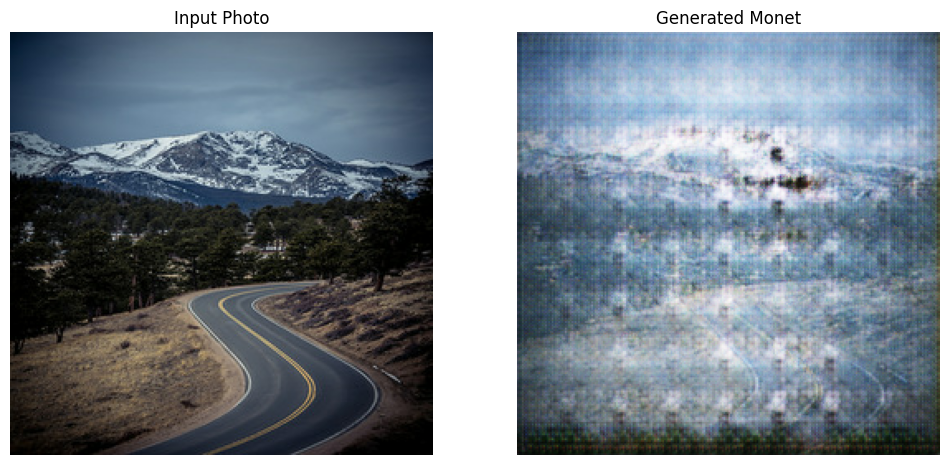

In [34]:
import matplotlib.pyplot as plt

def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Generated Monet']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Rescale from [-1, 1] to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()

# Pick a sample from test set
for example_input in test_photo.take(1):
    generate_images(generator_f, example_input)
